<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Use Apache SystemML and Spark for machine learning

This notebook introduces Apache SystemML and shows examples of running different forms of Linear Regression (Direct Solve, Batch Gradient Descent and Conjugate Gradient).  The code snippets are adapted from Apache SystemML __<a href="http://systemml.apache.org/get-started" target="_blank" rel="noopener noreferrer">sample notebooks</a>__ and run on Python 3.5 with Spark 2.1.  Some familiarity with Python and machine learning algorithms is recommended.


## Table of Contents

- [Apache SystemML](#systemml)<br>
- [Matrix Multiplication](#matrix-multiply)<br>
- [Linear Regression "out-of-the-box"](#linear-regression)<br>
- [Linear Regression Direct Solve](#direct-solve)<br>
- [Linear Regression Batch Gradient Descent](#gradient-descent)<br>
- [Linear Regression Conjugate Gradient](#conjugate-gradient)<br>
- [Linear Regression using scikit-learn interface](#linear-regression-api)<br>
- [Learn more](#summary)

<a id="systemml"></a>
## Apache SystemML

Apache SystemML is a powerful, flexible library for scalable machine learning.  It contains many popular machine learning algorithms (e.g., regression, clustering, classification, descriptive statistics) that can be used out-of-the-box or customized if necessary.  Algorithms are written in Python-like or R-like scripting languages intuitive to a Data Scientist familiar with Python or R.  Higher-level abstractions that encapsulate well-known algorithms are also provided for a Data Scientist to get started without needing to know the script implementation details.

#### Machine learning development challenges
Typically a Data Scientist writes and evaluates a machine learning algorithm with small data on a single machine. To apply the algorithm to big data in a clustered environment often requires an experienced Systems Engineer familiar with distributed programming.  However, an algorithm migrated to run on a large scale environment may not produce the same expected results due to problems in original algorithm or errors in converting the algorithm to run on a cluster.   Revising the algorithm ends up being an error-prone, time-consuming process since the Systems Engineer doesn't have expertise with the algorithm and the Data Scientist isn't familiar with distributed programming.

#### Apache SystemML to the rescue
Apache SystemML eliminates these algorithm development issues since it creates an optimized program that adapts to data characteristics.  A Data Scientist can focus on algorithm development and let Apache SystemML distribute processing as needed when that same algorithm is run with bigger data on larger environment.

#### Ease of use
Apache SystemML functionality can be accessed from Python, Scala and Java application programming interfaces.  Batch processing (e.g., spark-submit) is also supported.  Apache SystemML is a pre-installed library and available in Watson Studio with Spark so no separate installation is required.  For example, use pip to show available version.

In [ ]:
!pip show systemml

<a id="matrix-multiply"></a>
## Matrix Multiplication

Apache SystemML contains many __<a href="http://apache.github.io/systemml/dml-language-reference.html#built-in-functions" target="_blank" rel="noopener noreferrer">built-in functions</a>__ for handling linear algebra operations.  Here's a simple example showing how to create a script that generates a random matrix, multiplies the matrix with its transpose, and computes the sum of the output.  It also demonstrates use of Apache SystemML's __<a href="http://apache.github.io/systemml/spark-mlcontext-programming-guide" target="_blank" rel="noopener noreferrer">MLContext Application Programming Interface (API)</a>__ to execute the program.

In [2]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    X = rand(rows=$nr, cols=1000, sparsity=0.5)
    A = t(X) %*% X
    s = sum(A)
"""

prog = dml(script).input('$nr', 1e5).output('s')
s = ml.execute(prog).get('s')
print(s)

6260654651.1


<a id="linear-regression"></a>
## Linear Regression "out-of-the-box"

Apache SystemML has a large selection of __<a href="https://apache.github.io/systemml/algorithms-reference.html" target="_blank" rel="noopener noreferrer">algorithm implementations</a>__ that can be used without modifications.  For this example, an existing algorithm will be loaded and executed.  First, setup diabetes datasets from scikit-learn.

In [3]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

In the next snippet, an existing implementation of Linear Regression Direct Solve is retrieved and run with diabetes input data.

In [4]:
from systemml import MLContext, dml, dmlFromResource

ml = MLContext(sc)

dml_script = dmlFromResource("/scripts/algorithms/LinearRegDS.dml")

prog = dml_script.input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()
bias=w[1]
print(bias)

[ 152.91886229]


The results can be displayed graphically using matplotlib as shown below.

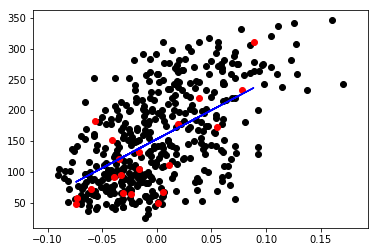

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='blue')

<a id="direct-solve"></a>
## Linear Regression Direct Solve

### Least squares formulation
w* = argminw ||Xw-y||2 = argminw (y - Xw)'(y - Xw) = argminw (w'(X'X)w - w'(X'y))/2

### Setting the gradient
dw = (X'X)w - (X'y) to 0, w = (X'X)-1(X' y) = solve(X'X, X'y)

This example uses diabetes datasets from scikit-learn which can be pre-loaded as follows.

In [6]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

The following cell creates and runs a script using Apache SystemML that generates a small Spark job for distributed data processing.

In [7]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

Display the results with matplotlib.

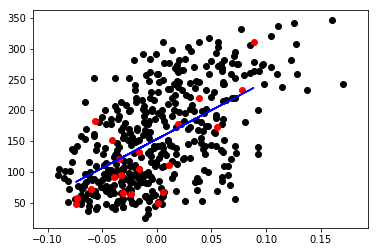

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue')

<a id="gradient-descent"></a>
## Linear Regression Batch Gradient Descent

#### Algorithm
`Step 1: Start with an initial point 
while(not converged) { 
  Step 2: Compute gradient dw. 
  Step 3: Compute stepsize alpha.     
  Step 4: Update: wnew = wold + alpha*dw 
}`

#### Gradient formula
`dw = r = (X'X)w - (X'y)`

#### Step size formula
`Find number alpha to minimize f(w + alpha*r) 
alpha = -(r'r)/(r'X'Xr)`


For input data, load the diabetes datasets from scikit-learn as shown below.

In [9]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

Create and execute an Apache SystemML script that uses Spark to distribute data processing.

In [10]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()


Visualize the results with matplotlib.

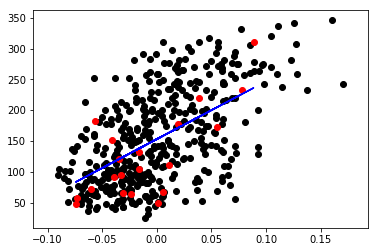

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue')

<a id="conjugate-gradient"></a>
## Linear Regression Conjugate Gradient

A problem with gradient descent is that it takes very similar directions many times.  Modifying the original gradient descent algorithm with an additional step to enforcing conjugacy resolves this issue.

`Step 1: Start with an initial point 
while(not converged) {
   Step 2: Compute gradient dw.
   Step 3: Compute stepsize alpha.
   Step 4: Compute next direction p by enforcing conjugacy with previous direction.
   Step 5: Update: w_new = w_old + alpha*p
}`


To get started with sample data, load the diabetes datasets from scikit-learn.

In [12]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

Define the algorithm in Apache SystemML's scripting language and execute the corresponding program using __<a href="http://apache.github.io/systemml/spark-mlcontext-programming-guide" target="_blank" rel="noopener noreferrer">MLContext Application Programming Interface (API)</a>__.

In [13]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()


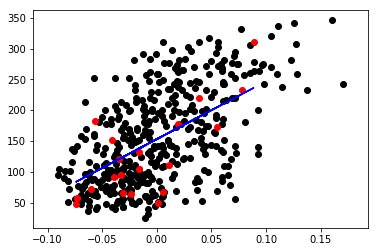

In [14]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue')

<a id="linear-regression-api"></a>
## Linear Regression using scikit-learn interface

Python developers can use the __<a href="https://apache.github.io/systemml/python-reference#mllearn-api" target="_blank" rel="noopener noreferrer">mllearn interface</a>__ from Apache SystemML to invoke algorithms with scikit-learn.

For this example, the diabetes datasets from scikit-learn are used.

In [15]:
from sklearn import datasets
import numpy as np

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

diabetes.data.shape

(442, 10)

The next cell runs __<a href="https://apache.github.io/systemml/algorithms-regression.html#linear-regression" target="_blank" rel="noopener noreferrer">Linear Regression</a>__ against the sample data taking approximately sixteen Spark jobs to complete processing.  Since the number of features in the sample dataset is small, Linear Regression Direct Solve is used with `solver='direct-solve'`.  To switch to Linear Regression Conjugate Gradient, specify `solver='newton-cg'`.

In [16]:
from systemml.mllearn import LinearRegression

regr = LinearRegression(spark, solver='direct-solve', transferUsingDF=True)
regr.fit(diabetes_X_train, diabetes_y_train)
mllearn_predicted = regr.predict(diabetes_X_test)

Utilities from sklearn can be used to score the results as shown below.

In [17]:
from sklearn import linear_model
from sklearn.metrics import r2_score

sklearn_regr = linear_model.LinearRegression()
sklearn_regr.fit(diabetes_X_train, diabetes_y_train)

score = r2_score(sklearn_regr.predict(diabetes_X_test), mllearn_predicted)
print('Linear Regression score: %f' % score)

Linear Regression score: 1.000000


<a id="summary"></a>
## Learn more

Visit __<a href="http://systemml.apache.org/" target="_blank" rel="noopener noreferrer">Apache SystemML</a>__ for additional examples and documentation.  For questions or requests for more information, please use the __<a href="http://apache.github.io/systemml/contributing-to-systemml#development-mailing-list" target="_blank" rel="noopener noreferrer">development mailing list</a>__.  To get involved, see __<a href="http://apache.github.io/systemml/contributing-to-systemml" target="_blank" rel="noopener noreferrer">contributing to Apache SystemML</a>__ for details.

<a id="authors"></a>
### Authors

This notebook is built upon __<a href="https://github.com/apache/systemml/graphs/contributors" target="_blank" rel="noopener noreferrer">contributions from developers</a>__ of Apache SystemML.  **Arvind Surve** is an architect at IBM in San Jose, California.  He has been an active committer for Apache SystemML since it was initially contributed to open source and has written a __<a href="http://www.spark.tc/tutorial-declarative-ml/" target="_blank" rel="noopener noreferrer">Declarative Machine Learning Tutorial</a>__ with Apache SystemML.  **Glenn Weidner** is a software developer at IBM in San Francisco, California.  He's a member of the __<a href="http://www.spark.tc/" target="_blank" rel="noopener noreferrer">Spark Technology Center</a>__ and also a committer for Apache SystemML.

<hr>
Copyright &copy; IBM Corp. 2017, 2018. This notebook and its source code are released under the terms of the MIT License.